# Uma CNN estimada usando otimizador

Objetivos:
 - Implementar uma DenseNet
 - com as decisões arquiturais realizadas pelo TPE
 - numa otimização SMBO

## Pre-requisitos

In [21]:
!pip install hyperopt
!pip install pymongo

In [1]:
import numpy as np
import sklearn as sk
import os
from sklearn.model_selection import train_test_split
import random
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.optimizers import SGD, Adam
from sklearn import metrics
from keras import metrics
from keras.models import load_model, Model

from hyperopt import hp
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt import STATUS_OK, STATUS_FAIL


import json
from bson import json_util

import keras.backend as K
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

import traceback
import pickle
import uuid




2025-02-25 10:04:09.023418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 10:04:09.210159: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 10:04:09.291574: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 10:04:09.920701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# !mkdir results

In [3]:
!ls -l /

total 2097248
drwxr-xr-x   8 bruna root       4096 fev 24 15:32 backup
lrwxrwxrwx   1 root  root          7 jun 12  2023 bin -> usr/bin
drwxr-xr-x   4 root  root       4096 fev 24 10:24 boot
drwxrwxr-x   2 root  root       4096 jun 12  2023 cdrom
drwxr-xr-x  21 root  root       4780 fev 25 09:35 dev
drwxr-xr-x 140 root  root      12288 fev 25 09:53 etc
drwxr-xr-x   5 root  root       4096 fev 13 13:29 home
-rwxr-xr-x   1 root  root        459 mar 20  2020 install-script.sh
lrwxrwxrwx   1 root  root          7 jun 12  2023 lib -> usr/lib
lrwxrwxrwx   1 root  root          9 jun 12  2023 lib32 -> usr/lib32
lrwxrwxrwx   1 root  root          9 jun 12  2023 lib64 -> usr/lib64
lrwxrwxrwx   1 root  root         10 jun 12  2023 libx32 -> usr/libx32
drwx------   2 root  root      16384 jun 12  2023 lost+found
drwxr-xr-x   5 root  root       4096 out 23 09:12 media
drwxr-xr-x   2 root  root       4096 ago 19  2021 mnt
drwxr-xr-x   6 root  root       4096 fev 13 12:52 opt
dr-xr-xr-x 512 root  ro

## Globais

In [ ]:
#globais

#define o tamanho padrão das imagens que serão passadas na rede, sendo que a mesma aceita imagens maiores que o padrão definido da VGG16 (255x255)
img_width = 224
img_height = 224

batch_size = 16 #batch_size para o treino

#define o batch_size de validação, das imagens de acordo com a memória disponivél na máquina
batch_size_val = 16

#define as épocas
epochs = 2

eps = 1.1e-5

num_classes_exp = 3

RESULTS_DIR = "results/" #pasta para salvar os resultados dos treinamentos

## Utils

In [5]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [6]:
def save_json_result(model_name, result):
    """Save json to a directory and a filename."""
    result_name = '{}.txt.json'.format(model_name)
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    with open(os.path.join(RESULTS_DIR, result_name), 'w') as f:
        json.dump(
            result, f,
            default=json_util.default, sort_keys=True,
            indent=4, separators=(',', ': ')
        )


## Etapa 1: Dataset

In [7]:
# Dataset Pneumonia

# Caminho local para as imagens
dataset_path = 'chest_pneumonia'

# Carregar as imagens de treino e validação usando glob
train_images = glob.glob(f'{dataset_path}/train/*/*')  # Arquivos de treino
# val_images = glob.glob(f'{dataset_path}/val/*/*')  # Arquivos de validação

# Combinar os dois conjuntos
# filenames = train_images + val_images

# Dividir em treino e validação (80% para treino, 20% para validação)
# train_filenames, val_filenames = train_test_split(filenames, test_size=0.2) 

In [8]:
COUNT_NORMAL = len([filename for filename in train_images if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_BACTERIA= len([filename for filename in train_images if "BACTERIA" in filename])
print("Bacterial Pneumonia images count in training set: " + str(COUNT_BACTERIA))

COUNT_VIRUS = len([filename for filename in train_images if "VIRUS" in filename])
print("Viral Pneumonia images count in training set: " + str(COUNT_VIRUS))

# COUNT_NORMAL_val = len([filename for filename in val_filenames if "NORMAL" in filename])
# print("Normal images count in training set: " + str(COUNT_NORMAL_val))

# COUNT_PNEUMONIA_val = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
# print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA_val))

Normal images count in training set: 1341
Bacterial Pneumonia images count in training set: 2538
Viral Pneumonia images count in training set: 1345


In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
        for item in tf.io.gfile.glob(os.path.join(dataset_path, "train", "*"))
        if tf.io.gfile.isdir(item)  # Filtra apenas diretórios
        ]) 

CLASS_NAMES

2025-02-25 10:04:10.951740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-25 10:04:10.980613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-25 10:04:10.981096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-25 10:04:10.983024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

array(['NORMAL', 'BACTERIA', 'VIRUS'], dtype='<U8')

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory="chest_pneumonia/train",
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

# val_generator = train_datagen.flow_from_directory(
#     directory="chest_xray/val",
#     target_size=(224, 224),
#     color_mode="rgb",
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=True,
# )
test_generator = train_datagen.flow_from_directory(
    directory="chest_pneumonia/test",
    target_size=(img_width, img_height), #?
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 5224 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


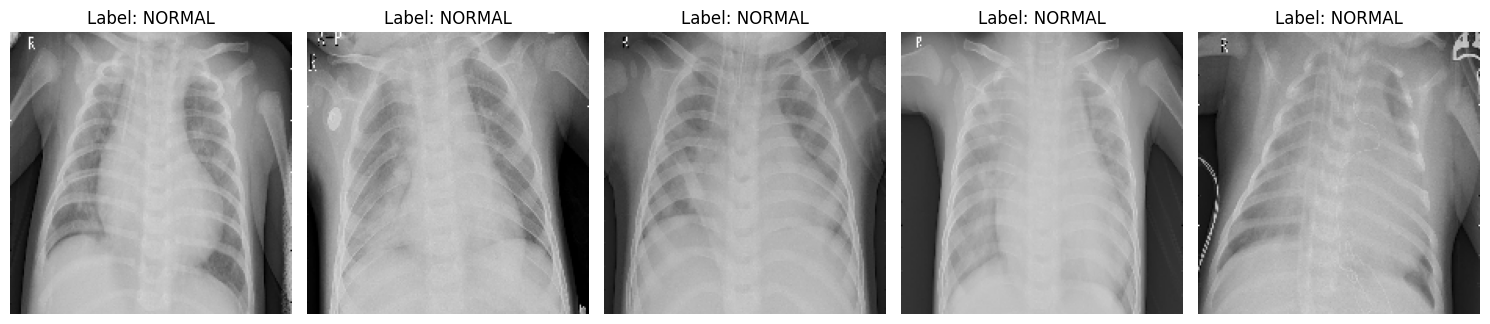

In [12]:
import matplotlib.pyplot as plt
import numpy as np


# Pegando um batch do gerador
x,y= next(train_generator)

# Número de imagens a serem exibidas (máximo de 5 ou total disponível)
num_images = min(5, len(x))

# Criando a figura
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    axes[i].imshow(x[i])  # Exibindo a imagem
    label = CLASS_NAMES[np.argmax(y[i])]  # Encontrando a classe com maior probabilidade
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# from keras.datasets import fashion_mnist
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [14]:
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)

# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

## Etapa 2: Montando o modelo baseado na função objetivo

Objetivo: construir uma densenet de acordo com os parâmetros que o otmizador enviar

In [74]:
'''
def H( inputs, num_filters , dropout_rate ):
    x = layers.BatchNormalization( epsilon=eps )( inputs )
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1, 1))(x)
    x = layers.SeparableConv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(x)
    x = layers.Dropout(rate=dropout_rate )(x)
    return x
'''
def H( inputs, num_filters , dropout_rate ):
    x = layers.BatchNormalization( epsilon=eps )( inputs )
    x = layers.Activation('relu')(x)

    out_conv = []
    for i in [(1,1),(3,3),(5,5),(0,0)]:
        p = x
        if i == (1,1):
                p = layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p)
                out_conv.append(layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p))
        elif i == (0,0):
                p = layers.MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p))
        else:
                p = layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p)
                p = layers.SeparableConv2D(num_filters, i, padding="same",activation="relu")(p)
                out_conv.append(layers.SeparableConv2D(num_filters, i, padding="same",activation="relu")(p))

    x = layers.concatenate(out_conv, axis = -1)
    x = layers.Dropout(rate=dropout_rate )(x)
    return x

def transition(inputs, num_filters , compression_factor , dropout_rate ):
    # compression_factor is the 'θ'
    x = layers.BatchNormalization( epsilon=eps )(inputs)
    x = layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1] # The value of 'm'

    x = layers.Conv2D( np.floor(num_feature_maps * compression_factor) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' , kernel_initializer='he_normal')(x)
    x = layers.Dropout(rate=dropout_rate)(x)

    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate ):
    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = H(inputs, num_filters , dropout_rate )
        inputs = layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters

def build_model(input_shape,
           num_blocks,
           num_layers_per_block,
           growth_rate,
           dropout_rate,
           compress_factor,
           num_filters,
           num_classes):
    
    # input_shape = ( 32 , 32 , 3 )
    num_blocks = 1
    num_layers_per_block = 2
    growth_rate = 16
    dropout_rate = 0.2
    compress_factor = 1

    num_filters = 32
    

    inputs = layers.Input( shape=input_shape )
    x = layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , padding="same", use_bias=False, kernel_initializer='he_normal')( inputs )
    for i in range( num_blocks ):
        x, num_filters = dense_block( x, num_layers_per_block , num_filters, growth_rate , dropout_rate )
        x = transition(x, num_filters , compress_factor , dropout_rate )

    x = layers.GlobalAveragePooling2D()( x )
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense( num_classes )( x )
    outputs = layers.Activation( 'softmax' )( x )

    model = Model( inputs , outputs )
    model.compile( loss='categorical_crossentropy' ,optimizer=Adam( learning_rate=0.0001 ), metrics=['accuracy'])
    return model

In [75]:
import tensorflow as tf

# Verifica se TensorFlow está detectando a GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("A GPU foi detectada!")
else:
    print("Nenhuma GPU foi detectada.")


A GPU foi detectada!


## Etapa 3: Configurando a Otimização


In [76]:
def build_and_train(hype_space):
    print (hype_space)

    model_final = build_model(input_shape=(img_width, img_height, 3), 
            num_blocks = int(hype_space['num_blocks']),
            num_layers_per_block = int(hype_space['num_layers_per_block']),
            growth_rate = int(hype_space['growth_rate']),
            dropout_rate = hype_space['dropout_rate'],
            compress_factor = hype_space['compress_factor'],
            num_filters = hype_space['num_filters'],
            num_classes = num_classes_exp)

    model_size = keras_model_memory_usage_in_bytes(model = model_final,
                        batch_size = batch_size)
    model_size = model_size/1000000000
    print("aqui é o model size")
    print(model_size)

    print("Model size: " + str(model_size) )
    if (model_size > 10.5): 
        model_name = "model_" + str(uuid.uuid4())[:5]
        result = {
            'space': hype_space,
            'status': STATUS_FAIL
        }
        return model_final, model_name, result
    
    print("daqui eu nao passo")

    #inicio da fase de treino
    #as imagens são passadas na rede
    early_stopping = EarlyStopping(monitor='loss', patience=3,
                                    verbose=1, mode='auto', restore_best_weights=True)
    checkpoint = ModelCheckpoint('weights_best_etapa1.hdf5', monitor='loss',
                                verbose=1,
                                save_best_only=True, mode='auto')

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1)

    model_final.fit(train_generator,
                                epochs=epochs,
                                # validation_data=[x_test, y_test],
                                # validation_steps=batch_size_val,
                                verbose=2, callbacks=[early_stopping,checkpoint,reduce_lr])

    y_pred = model_final.predict(test_generator)
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = test_generator.labels[:len(y_pred)]

    f1 = f1_score(y_true, y_pred, average='weighted')
    class_report = classification_report(y_true, y_pred)
    
    model_name = "model_{}_{}".format(str(f1), str(uuid.uuid4())[:5])

    result = {
        'loss': 1-f1,
        'f1': f1,
        'report': class_report,
        'model_name': model_name,
        'space': hype_space,
        'status': STATUS_OK
    }

    print(result)

    return model_final, model_name, result

## Etapa 4: Executando a otimização

In [77]:
#código de # https://github.com/hyperopt/hyperopt/issues/267
def optimize_cnn(hype_space):
    """Build a convolutional neural network and train it."""
    try:
        model, model_name, result = build_and_train(hype_space)

        # Save training results to disks with unique filenames
        save_json_result(model_name, result)

        K.clear_session()
        del model

        return result

    except Exception as err:
        try:
            K.clear_session()
        except:
            pass
        err_str = str(err)
        print(err_str)
        traceback_str = str(traceback.format_exc())
        print(traceback_str)
        return {
            'status': STATUS_FAIL,
            'err': err_str,
            'traceback': traceback_str
        }

    print("\n\n")

In [78]:
#código de # https://github.com/hyperopt/hyperopt/issues/267
def run_a_trial():
    """Run one TPE meta optimisation step and save its results."""
    max_evals = nb_evals = 1

    print("Attempt to resume a past training if it exists:")

    try:
        trials = pickle.load(open("results.pkl", "rb"))
        print("Found saved Trials! Loading...")
        max_evals = len(trials.trials) + nb_evals
        print("Rerunning from {} trials to add another one.".format(
            len(trials.trials)))
    except:
        trials = Trials()
        print("Starting from scratch: new trials.")

    best = fmin(
        optimize_cnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=max_evals
    )
    pickle.dump(trials, open("results.pkl", "wb"))

    print("\nOPTIMIZATION STEP COMPLETE.\n")

In [79]:
space = {
    'num_blocks': hp.choice('num_blocks', [2]),
    'num_layers_per_block' : hp.choice('num_layers_per_block', [2]),
    'growth_rate': hp.choice('growth_rate', [16]),
    'dropout_rate' : hp.uniform('dropout_rate', 0.2, 0.35),
    'compress_factor' : hp.choice('compress_factor', [1]),
    'num_filters' : hp.choice('num_filters', [32])
}


In [80]:
if __name__ == "__main__":

  #executa indefinidamente
  # while True:

    try:
      run_a_trial()
    except Exception as err:
      err_str = str(err)
      print(err_str)
      #traceback_str = str(traceback.format_exc())
      #print(traceback_str)


Attempt to resume a past training if it exists:
Starting from scratch: new trials.
{'compress_factor': 1, 'dropout_rate': 0.25552193733469214, 'growth_rate': 16, 'num_blocks': 2, 'num_filters': 32, 'num_layers_per_block': 2}
aqui é o model size                                  
7.448570611                                          
Model size: 7.448570611                              
daqui eu nao passo                                   
Epoch 1/2                                            

                                                     
Epoch 1: loss improved from inf to 0.79013, saving model to weights_best_etapa1.hdf5

327/327 - 126s - loss: 0.7901 - accuracy: 0.6470 - lr: 1.0000e-04 - 126s/epoch - 385ms/step

Epoch 2/2                                            

                                                     
Epoch 2: loss improved from 0.79013 to 0.66039, saving model to weights_best_etapa1.hdf5

327/327 - 123s - loss: 0.6604 - accuracy: 0.7125 - lr: 1.0000e-04 - 123s

/home/bruna/miniconda3/envs/bruna/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/home/bruna/miniconda3/envs/bruna/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/home/bruna/miniconda3/envs/bruna/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize